In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import os

In [5]:
%store -r df_Xy

In [6]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 363 entries, gbp_rate to gold_dif_lag10
dtypes: float64(363)
memory usage: 8.4 MB


# We want to investigate the predictivty of central bank policy rates and stock market index performance as they relate to the price of gold. 
## The core question here is if the addition of central bank rates and stock market indices to a model can outperform a model that only uses gold's price and an up to a 10 period lag as a features.

## We'll attempt to use time series modeling to predict the daily price, daily price difference, and daily percent change in price of gold.
### We have the most recent 10 years of daily data from the following sources:
### Features:
#### Top 5 equity market indices by market capitalization, per Statista: https://www.statista.com/statistics/270126/largest-stock-exchange-operators-by-market-capitalization-of-listed-companies/, and their corresponding daily performance and percent change
NYSE Composite Index history: https://finance.yahoo.com/quote/%5ENYA?p=^NYA&.tsrc=fin-srch
NASDAQ Composite Index history: https://finance.yahoo.com/quote/%5EIXIC?p=^IXIC&.tsrc=fin-srch
Japan Exchange Group Composite Index history: https://finance.yahoo.com/quote/8697.T?p=8697.T&.tsrc=fin-srch
Shanghai Stock Exchange Composite Index history: https://finance.yahoo.com/quote/%5ESSEC?p=^SSEC&.tsrc=fin-srch
Hang Seng (Hong Kong) Index History: https://finance.yahoo.com/quote/%5EHSI?p=^HSI&.tsrc=fin-srch
#### Top 5 Currencies Globally in Forex Trading (https://www.ig.com/us/trading-strategies/top-10-most-traded-currency-pairs-191206), and their corresponding daily central bank policy rates and percent change
The Fed (USD): https://fred.stlouisfed.org/series/FEDFUNDS
ECB (EUR): https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html
BoJ (JPY): https://fred.stlouisfed.org/series/IRSTCI01JPM156N
United Kingdom (GBP): https://fred.stlouisfed.org/series/GBPONTD156N
Australia (AUD): https://www.rba.gov.au/statistics/cash-rate/
#### Daily price of gold  and percent change (up to 10-day lag): https://www.usagold.com/reference/prices/goldhistory.php

### Targets:
#### Daily price of gold, daily difference in gold price, daily percent change price of gold: https://www.usagold.com/reference/prices/goldhistory.php

## As the data sits, we currently have both daily policy rates and index scores (along with differences and percent changes) - each with up to a ten day lag on the data. This translates to  121 features each in our 3 would-be models (daily price, daily price difference, daily percent price change).

### Let's start by separating our data

In [7]:
# store column titles to create separate dataframes for raw values, differences, and percent changes

col_raw = []
col_dif = []
col_change = []

for col in df_Xy.columns:
    if 'change%' in col:
        col_change.append(col)
    elif 'dif' in col:
        col_dif.append(col)
    else:
        col_raw.append(col)

In [8]:
# create three separate dataframes, one with raw values, one with differences, and one with percent change

df_Xy_raw = df_Xy[col_raw].dropna()

df_Xy_dif = df_Xy[col_dif].dropna()

df_Xy_change = df_Xy[col_change].dropna()

In [9]:
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3022 entries, 2008-09-19 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [10]:
df_Xy_dif.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [11]:
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


#### To compare models on a level playing field, we need to ensure the same date range is being used for both the raw and the change data. Let's take a look at the date ranges in all of our datasets. It looks like our difference dataframe is the limiting factor here with '2008-09-22' being the earliest date in the dataset.

In [12]:
df_Xy_raw = df_Xy_raw[df_Xy_raw.index >= '2008-09-22']
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [13]:
df_Xy_change = df_Xy_change[df_Xy_change.index >= '2008-09-22']
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [14]:
# create X,y pairs for both raw and percent change dataframes

X_raw = df_Xy_raw.drop(columns = ['gold'])
y_raw = df_Xy_raw['gold']

X_dif = df_Xy_dif.drop(columns = ['gold_dif'])
y_dif = df_Xy_dif['gold_dif']

X_change = df_Xy_change.drop(columns = ['gold_change%'])
y_change = df_Xy_change['gold_change%']

## EDA
### Historical Gold Data Trends and Moving Averages

In [21]:
# We default the window here to 365 as we have daily data, and we want to average-out seasonal patterns, if they exist
def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

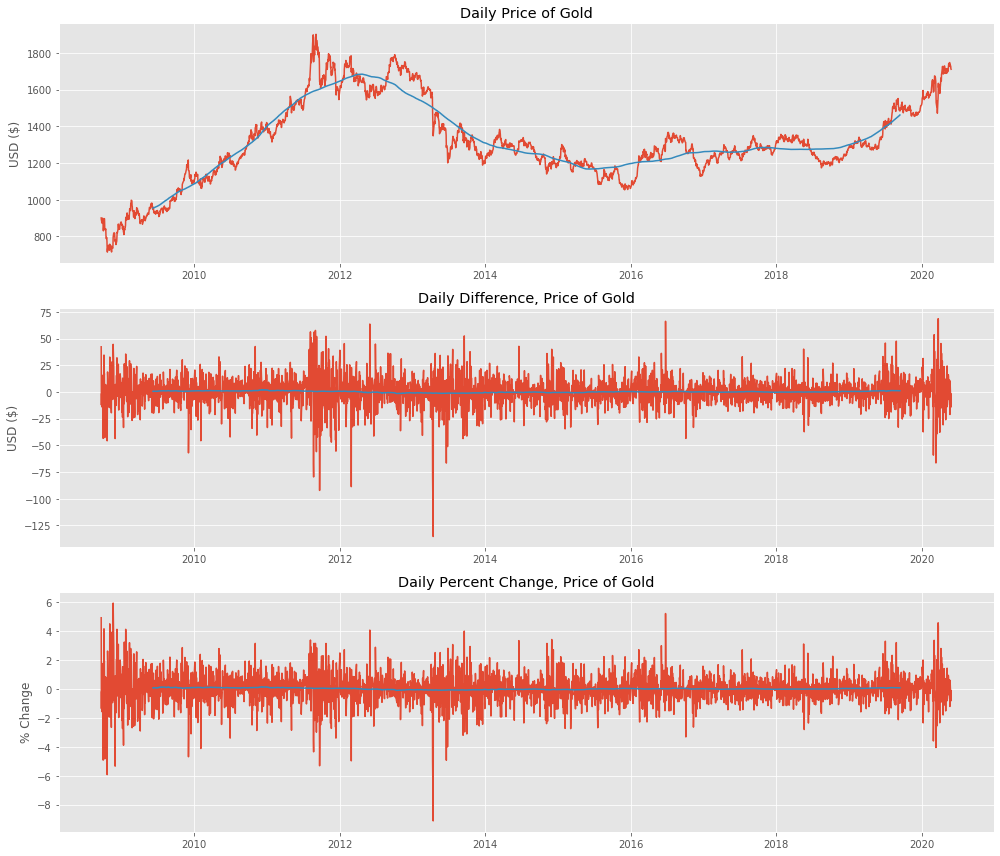

In [18]:
fig,axs = plt.subplots(3,1, figsize = (14,12))

for ax,metric,series in zip(axs,[('Daily Price of Gold','USD ($)'), ('Daily Difference, Price of Gold','USD ($)'),\
                            ('Daily Percent Change, Price of Gold','% Change')],[y_raw,y_dif,y_change]):
        
        ma = fit_moving_average_trend(series)
        ax.plot(series.index,series)
        ax.plot(series.index,ma, label = 'Moving Average')
        ax.set_title(metric[0])
        ax.set_ylabel(metric[1])
plt.tight_layout()        

## EDA
### Testing for Stationarity with Augmented Dickey Fuller

In [26]:
for title, series in zip(['Daily Price of Gold', 'Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_raw,y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    print(f'{title} ADF p-value: {round(test[1],3)}')

Daily Price of Gold ADF p-value: 0.397
Daily Difference, Price of Gold ADF p-value: 0.0
Daily Percent Change, Price of Gold ADF p-value: 0.0


So we now know that both gold's Daily Price Difference and Daily Percent Change are stationary.
Let's take a look at some autocorrelation and partial autocorrelation plots to see if an AR (auto-regressive) model  would make sense for our baselines

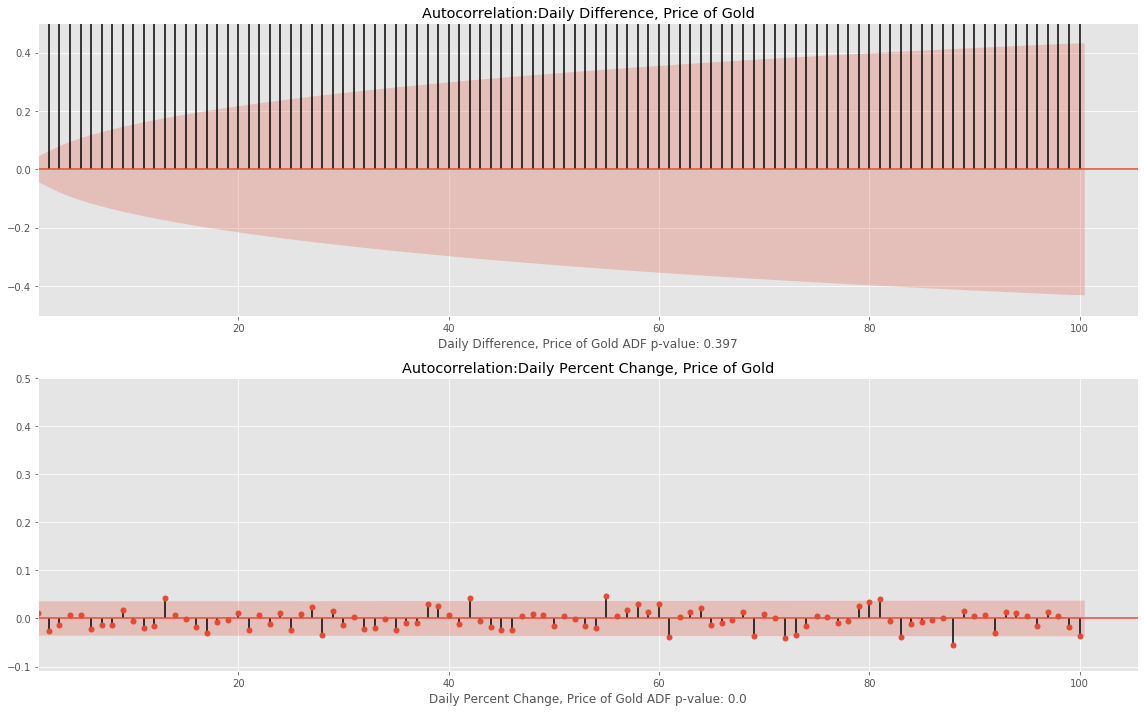

In [27]:
fig, axs = plt.subplots(2, figsize=(16, 10))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_raw,y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_acf(series, lags=100, ax=ax)
    ax.set_title(f'Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.5)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()

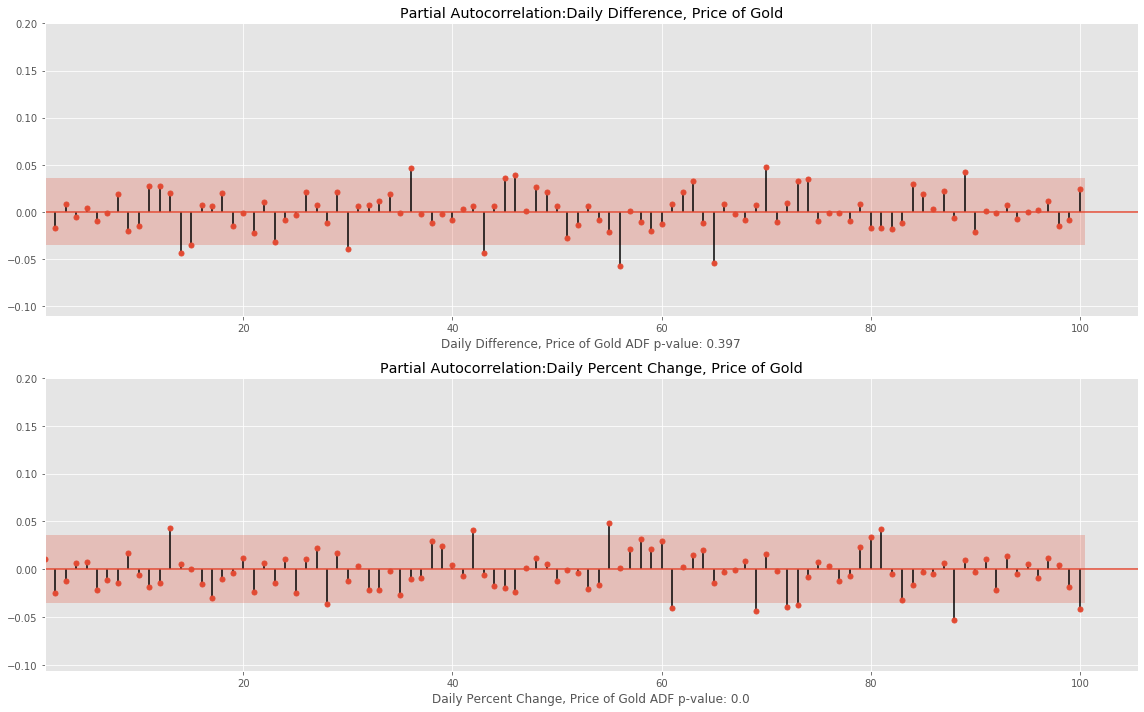

In [29]:
fig, axs = plt.subplots(2, figsize=(16, 10))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_raw,y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_pacf(series, lags=100, ax=ax)
    ax.set_title(f'Partial Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.2)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()